# Sales Outreach Email Engagement Analysis 
Author: Sangy Hanumasagar, 30 April 2018 <br>
Python 3.6.2

## Table of Contents

#### Part I
1. Introduction 
2. Exploratory Data Analysis, Preprocessing and Feature Selecion

#### Part II
3. Class Imbalance
4. Imputing Missing Values
5. ML Model Comparison and Selection

#### Part III
5. Undersampling
6. Model Model Performance & Hyperparameter Tuning
7. Interpretation of Results and Feature Importance
8. Closing Thoughts

In [402]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

plt.style.use('bmh')

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

Lets read the dataframe from the first notebook.

In [101]:
%store -r full_df

In [102]:
print('No of positve and negative examples:')
full_df['email_opened'].value_counts()

No of positve and negative examples:


0    745829
1    277427
Name: email_opened, dtype: int64

### Class Imbalance
Our dataset target classes are imbalanced by 73:23 proportion. So training a model on this data directly would result in bias and the positive class being underpredicted. For such cases accuracy can be high but the model isn't doing its job. 


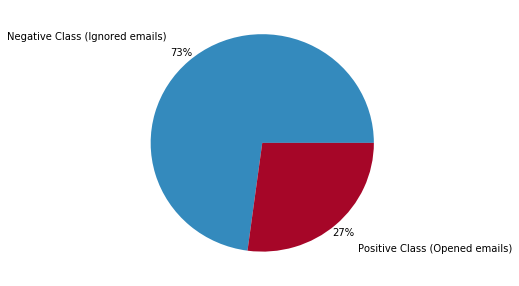

In [103]:
class_counts=full_df['email_opened'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['Negative Class (Ignored emails)','Positive Class (Opened emails)'], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3)
plt.show()


#### Options

We can resample the data before training to balance the classes, by either random undersampling, oversampling, or generating synthetic data (Synthetic Minority Over-sampling Technique). 

There are also tree-based algorithms that will allow us to increase minoroty samples weight during training.

The key will be running many models multiple times and using cross validation to get confidence in the results and ensure model generalizes. I will also use multiple metrics like confusion matrix, precisiona, recall, f1-score and ROC curves.

In [104]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 25 columns):
is_thread_reply            1023256 non-null int64
subject_customized         1023256 non-null int64
body_customized            1023256 non-null int64
subject_length             454321 non-null float64
body_length                1012846 non-null float64
delivered_at               1023256 non-null datetime64[ns]
replied_at                 31137 non-null datetime64[ns]
opened_at                  277427 non-null datetime64[ns]
clicked_at                 3134 non-null datetime64[ns]
sequence_id                1023256 non-null int64
persona                    1023256 non-null object
company_name               1022356 non-null object
industry                   987681 non-null object
company_tier               939426 non-null object
email_opened               1023256 non-null int32
email_replied              1023256 non-null int32
delivered_at_day           1023256 non-null int64
de

Notes:
* The 'datetime' fields can be dropped. The delivered_at field has already been used to extract days and hours of delivery.
* 'email_replied' doesnt apply to binary classification as we are dealing with email_opened as target field here.

In [105]:
model_df=full_df.drop(['delivered_at','replied_at','opened_at','opened_at_day', 'opened_at_hour', 'replied_at_day',
                       'replied_at_hour','clicked_at','email_replied','industry'],axis=1)
model_df.drop([],axis=1,inplace=True)

In [106]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 15 columns):
is_thread_reply            1023256 non-null int64
subject_customized         1023256 non-null int64
body_customized            1023256 non-null int64
subject_length             454321 non-null float64
body_length                1012846 non-null float64
sequence_id                1023256 non-null int64
persona                    1023256 non-null object
company_name               1022356 non-null object
company_tier               939426 non-null object
email_opened               1023256 non-null int32
delivered_at_day           1023256 non-null int64
delivered_at_hour          1023256 non-null int64
industy_category           1023256 non-null object
prospect_number_replies    1023256 non-null int32
sequence_length            1023256 non-null int64
dtypes: float64(2), int32(2), int64(7), object(4)
memory usage: 117.1+ MB


We have :
* 4 object features: persona, company_name, industry, company_tier
* 4 continuous numeric features: subject_length, body_length, prospect_number_replies, sequence_length                 
* 5 ordinal categorical features: is_thread_reply, subject_customized, body_customized, delivered_at_day, delivered_at_hour
* 1 target binary categorical feature: email_opened

##### All these features make sense intuitively that they could be driving the email engagements

### Imputing Missing Values

In [107]:
model_df.isnull().sum()

is_thread_reply                 0
subject_customized              0
body_customized                 0
subject_length             568935
body_length                 10410
sequence_id                     0
persona                         0
company_name                  900
company_tier                83830
email_opened                    0
delivered_at_day                0
delivered_at_hour               0
industy_category                0
prospect_number_replies         0
sequence_length                 0
dtype: int64

#### Company name and company_tier:
I will fill missing values as Unknown for company name, and most common values for industry and company tier (mode of the field).

In [108]:
model_df['company_name'].fillna('Unknown',inplace=True)

tier_mode=full_df['company_tier'].mode()
model_df['company_tier'].fillna(tier_mode[0],inplace=True)

#### Subject Length and Body Length:
I will use the mode to fill the missing values

In [109]:
sub_length_mode=full_df['subject_length'].mode()
print(sub_length_mode)
model_df['subject_length'].fillna(sub_length_mode[0],inplace=True)

body_length_mode=full_df['body_length'].mode()
print(body_length_mode)
model_df['body_length'].fillna(body_length_mode[0],inplace=True)

0    13.0
dtype: float64
0    327.0
dtype: float64


_ the mode of the subject length is 13. 13 characters in a subject seems very short? _

In [110]:
model_df.isnull().sum()

is_thread_reply            0
subject_customized         0
body_customized            0
subject_length             0
body_length                0
sequence_id                0
persona                    0
company_name               0
company_tier               0
email_opened               0
delivered_at_day           0
delivered_at_hour          0
industy_category           0
prospect_number_replies    0
sequence_length            0
dtype: int64

### One-hot encoding categorical variables
ML algorithms don't like strongs as input so I will encode the strong fields into binary one-hot encoded matrix. This will dimensionality to the data, but we currently only have 13 fields fields so it should be okay.

Company tier has only 6 unique categories and persona has 12 unique categories. Industry and company name are

In [111]:
persona_encoded=pd.get_dummies(model_df['persona'],prefix='persona')
company_tier_encoded=pd.get_dummies(model_df['company_tier'],prefix='comptier')
industry_encoded=pd.get_dummies(model_df['industy_category'],prefix='industry')

In [112]:
company_tier_encoded.head()

,comptier_Commercial,comptier_Enterprise,comptier_Mid-Market,comptier_Other,comptier_Small Business,comptier_Strategic
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [113]:
model_df.drop(['company_name','company_tier','persona','industy_category'],axis=1, inplace=True)

In [114]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 11 columns):
is_thread_reply            1023256 non-null int64
subject_customized         1023256 non-null int64
body_customized            1023256 non-null int64
subject_length             1023256 non-null float64
body_length                1023256 non-null float64
sequence_id                1023256 non-null int64
email_opened               1023256 non-null int32
delivered_at_day           1023256 non-null int64
delivered_at_hour          1023256 non-null int64
prospect_number_replies    1023256 non-null int32
sequence_length            1023256 non-null int64
dtypes: float64(2), int32(2), int64(7)
memory usage: 85.9 MB


### Forward Feature Selection using class weighted balancing in Decision Tree Classifier

I will run the model on numeric features only and then add the one-hot encoded features: <br>
1) Only Numeric features <br>
2) Numeric + industry +persona + company-tier<br>


_This will use the entire dataset using class balancing._

#### Only Numeric Features

In [96]:
#create training and testing data split in 95:05 ratio

X= model_df.drop('email_opened',axis=1).values
y= model_df['email_opened'].values

(X_train, X_test, y_train, y_test) = train_test_split(X,y,test_size=0.05)
print('Lengths of sub-datasets',len(X_train), len(y_train), len(X_test), len(y_test))

# train the model
print("[INFO] using DecisionTreeClassifier model")
model = DecisionTreeClassifier(max_depth=100,min_samples_leaf=5,class_weight='balanced')
model.fit(X_train, y_train)

# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = model.predict(X_test)
print("Classification Report: ",classification_report(y_test, predictions))

print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

Lengths of sub-datasets 972093 972093 51163 51163
[INFO] using DecisionTreeClassifier model
[INFO] evaluating...
Classification Report:               precision    recall  f1-score   support

          0       0.80      0.72      0.76     37320
          1       0.40      0.51      0.45     13843

avg / total       0.69      0.66      0.67     51163

Confusion Matrix: 
 [[26796 10524]
 [ 6806  7037]]


[ 0.00138752  0.00095063  0.          0.05300734  0.13553449  0.14238271
  0.09537989  0.14508275  0.26751643  0.15875825]


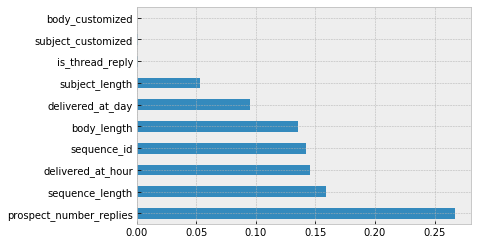

In [97]:
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=model_df.drop('email_opened',axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In all cases, the industry, company tier or persona fields did not improve the metric by much (confusion matrix, f1 score)


#### All Features

In [140]:
model_df_2= pd.concat([model_df, persona_encoded, company_tier_encoded,industry_encoded ], axis = 1)
model_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 32 columns):
is_thread_reply                 1023256 non-null int64
subject_customized              1023256 non-null int64
body_customized                 1023256 non-null int64
subject_length                  1023256 non-null float64
body_length                     1023256 non-null float64
sequence_id                     1023256 non-null int64
email_opened                    1023256 non-null int32
delivered_at_day                1023256 non-null int64
delivered_at_hour               1023256 non-null int64
prospect_number_replies         1023256 non-null int32
sequence_length                 1023256 non-null int64
persona_Ancillary               1023256 non-null uint8
persona_CSM/AM                  1023256 non-null uint8
persona_Executive Leadership    1023256 non-null uint8
persona_Marketing               1023256 non-null uint8
persona_Not Assigned            1023256 non-null uint8
per

In [388]:
#create training and testing data split in 95:05 ratio

X= model_df_2.drop('email_opened',axis=1).values
y= model_df_2['email_opened'].values

(X_train, X_test, y_train, y_test) = train_test_split(X,y,test_size=0.05)
print('Lengths of sub-datasets',len(X_train), len(y_train), len(X_test), len(y_test))

# train the model
print("[INFO] using DecisionTreeClassifier model")
model = DecisionTreeClassifier(max_depth=100,min_samples_leaf=5,class_weight='balanced')
model.fit(X_train, y_train)

# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = model.predict(X_test)
print("Classification Report: ",classification_report(y_test, predictions))

print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

Lengths of sub-datasets 972093 972093 51163 51163
[INFO] using RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) model
[INFO] evaluating...
Classification Report:               precision    recall  f1-score   support

          0       0.80      0.66      0.73     37152
          1       0.39      0.56      0.46     14011

avg / total       0.69      0.64      0.65     51163

Confusion Matrix: 
 [[24689 12463]
 [ 6155  7856]]


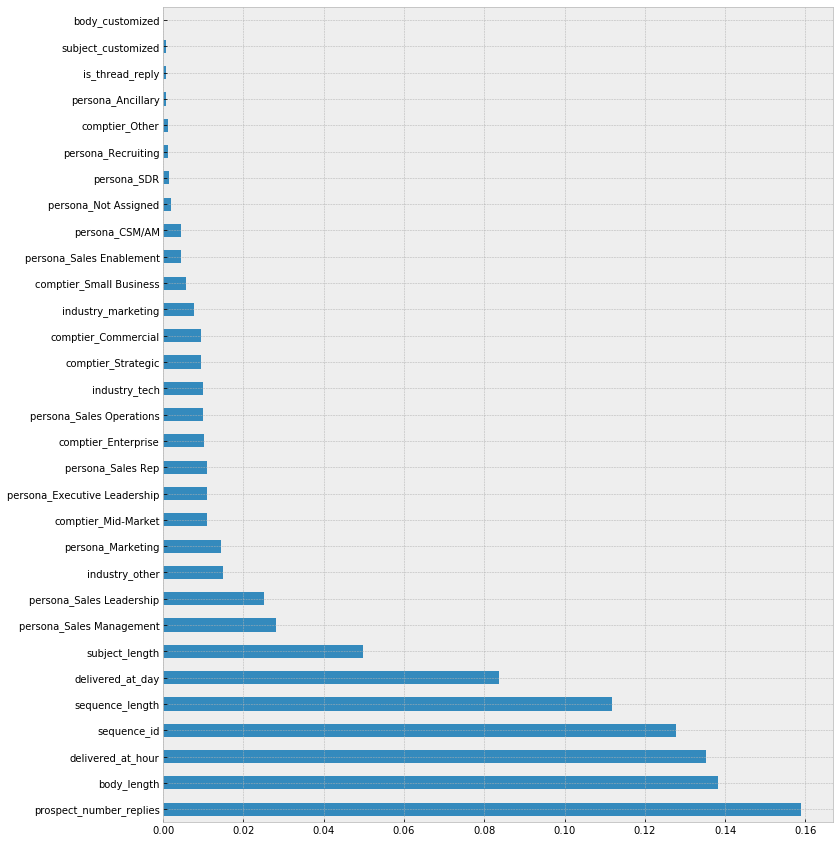

In [389]:
plt.figure(figsize=(12,15))
feat_importances = pd.Series(model.feature_importances_, index=model_df_2.drop('email_opened',axis=1).columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

Now, i will select only the top 23 features (the same as basline model with numeric features) so expedite tuning. 

In [390]:
selected_features=feat_importances.nlargest(23).keys()

In [391]:
final_model_df=model_df_2[selected_features]
final_model_df.loc[:,'email_opened']=model_df_2['email_opened']

C:\Users\shanumasagar3\AppData\Local\Continuum\Anaconda2\envs\py3env\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\shanumasagar3\AppData\Local\Continuum\Anaconda2\envs\py3env\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [392]:
final_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 24 columns):
prospect_number_replies         1023256 non-null int32
body_length                     1023256 non-null float64
delivered_at_hour               1023256 non-null int64
sequence_id                     1023256 non-null int64
sequence_length                 1023256 non-null int64
delivered_at_day                1023256 non-null int64
subject_length                  1023256 non-null float64
persona_Sales Management        1023256 non-null uint8
persona_Sales Leadership        1023256 non-null uint8
industry_other                  1023256 non-null uint8
persona_Marketing               1023256 non-null uint8
comptier_Mid-Market             1023256 non-null uint8
persona_Executive Leadership    1023256 non-null uint8
persona_Sales Rep               1023256 non-null uint8
comptier_Enterprise             1023256 non-null uint8
persona_Sales Operations        1023256 non-null uint8
ind

#### Create training and testing data split in 80:20 ratio

In [393]:
#create training and testing data split in 80:20 ratio

X= final_model_df.drop('email_opened',axis=1).values
y= final_model_df['email_opened'].values

(X_train, X_test, y_train, y_test) = train_test_split(X,y,test_size=0.2)
print('Lengths of sub-datasets',len(X_train), len(y_train), len(X_test), len(y_test))

Lengths of sub-datasets 818604 818604 204652 204652


#### DecisionTreeClassifier

In [394]:
# train the model
print("[INFO] using DecisionTreeClassifier model")
model = DecisionTreeClassifier(max_depth=100,min_samples_leaf=5,class_weight='balanced')
model.fit(X_train, y_train)

# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = model.predict(X_test)
print("Classification Report: ",classification_report(y_test, predictions))

print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

[INFO] using DecisionTreeClassifier model
[INFO] evaluating...
Classification Report:               precision    recall  f1-score   support

          0       0.80      0.66      0.72    149074
          1       0.38      0.55      0.45     55578

avg / total       0.68      0.63      0.65    204652

Confusion Matrix: 
 [[98351 50723]
 [24825 30753]]


#### Random Forest

In [231]:
# train the model
print("[INFO] using random forest model")
model = RandomForestClassifier(n_estimators=100,class_weight='balanced_subsample',n_jobs=4)
model.fit(X_train, y_train)

# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = model.predict(X_test)
print("Classification Report: ",classification_report(y_test, predictions))

print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

print(model.score(X=X_test,y=y_test))

Lengths of sub-datasets 818604 818604 204652 204652
[INFO] using random forest model
[INFO] evaluating...
Classification Report:               precision    recall  f1-score   support

          0       0.79      0.78      0.78    149225
          1       0.42      0.43      0.43     55427

avg / total       0.69      0.69      0.69    204652

Confusion Matrix: 
 [[116585  32640]
 [ 31622  23805]]
0.685988898227


[ 0.1325501   0.17211129  0.20840842  0.18140282  0.13969317  0.0983786
  0.0674556 ]


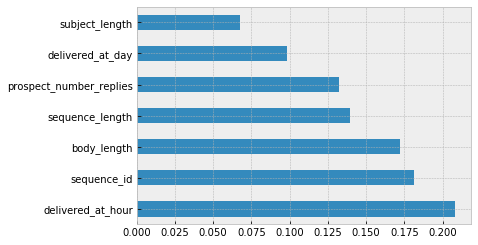

In [217]:
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=final_model_df.drop('email_opened',axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Compute ROC curve and ROC area for each class

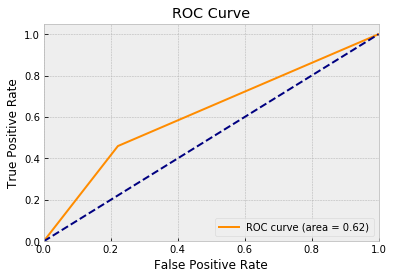

In [275]:

fpr, tpr,_= roc_curve(y_test, predictions, sample_weight=None)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


#### Precision Recall Curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py]

f1=0.581 auc=0.694 ap=0.562


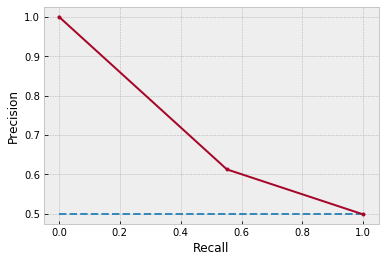

In [403]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
# calculate F1 score
f1 = f1_score(y_test, predictions)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, predictions)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### XGBoost

In [395]:

# specify parameters via map
msk = np.random.rand(len(X_train)) < 0.8
dtrain = xgb.DMatrix(X_train[msk],label=y_train[msk])
dtrain_watch = xgb.DMatrix(X_train[~msk], label=y_train[~msk])
evallist  = [(dtrain_watch, 'eval')]

dtest = xgb.DMatrix(X_test,label=y_test)

# specify parameters via map
param = {'max_depth':20, 'eta':1, 'silent':1, 'objective':'binary:logistic','scale_pos_weight':2.3 }
num_round = 10

bst = xgb.train(param, dtrain, num_round,evallist)

# make prediction
print("[INFO] evaluating...")
preds = bst.predict(dtest)
predictions=[round(value) for value in preds]

print("[INFO] evaluating...Done")

[0]	eval-error:0.310302
[1]	eval-error:0.313804
[2]	eval-error:0.315643
[3]	eval-error:0.315997
[4]	eval-error:0.318396
[5]	eval-error:0.318555
[6]	eval-error:0.319407
[7]	eval-error:0.319292
[8]	eval-error:0.319499
[9]	eval-error:0.319621
[INFO] evaluating...
[INFO] evaluating...Done


In [396]:
# make predictions on our data and show a classification report
print("Classification Report: ",classification_report(y_test, predictions))

print('Confusion Matrix: \n',confusion_matrix(y_test, predictions))

Classification Report:               precision    recall  f1-score   support

          0       0.79      0.77      0.78    149074
          1       0.42      0.46      0.44     55578

avg / total       0.69      0.68      0.69    204652

Confusion Matrix: 
 [[114079  34995]
 [ 30072  25506]]


##### All these models seem to be showing similar performance. 

As a general rule, proper feature engineering will have a much larger impact on model performance than even the most extensive hyperparameter tuning. It’s the law of diminishing returns applied to machine learning: feature engineering gets you most of the way there, and hyperparameter tuning generally only provides a small benefit.

In all the above cases, the precision and recall for the positive class (minority) class has been low owing to the false positives and false negatives. Maybe the class balancing of the models are not powerful, I am not sure. 


|  |0|1|
   |-|-|
|0|TN|FP|
|1|FN|TP|
 
 	
Precision = TP/(TP+FP)
Recall    = TP / (TP+FN)

So I will try something different and balance the classes by undersampling the majority class in the next notebook.



==================================================================================================================